In [2]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import itertools
from numpy.linalg import norm
from collections import Counter
import codecs
import tqdm
import scipy as sp
# NLP
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
# Machine Learning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
# Theme
from jupyterthemes import jtplot
jtplot.style()

In [3]:
# Function to remove punctuation from strings.
# Copied from Prof.
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

# Pre-processing

Non serve fare pre-processing: viene fatto in ```CADE_testing```.

# CADE

Analogo a sopra.

# Lexicon Processing

## Lexicon pre-processing

In [3]:
def clean_lexicon(x = None):
    if "#" in x:
        return(x.lower().split("#")[0])
    else:
        return(x.lower())

In [4]:
with open("./lexicon_2/inquirerbasic.csv", 'r') as file:
    lexicon = pd.read_csv(file)
    
lexicon = lexicon.dropna(how="all", subset=['Ovrst', 'Undrst'])
lexicon["Labels"] = lexicon["Undrst"].apply(lambda x: 1 if pd.isnull(x) else 0)
# lexicon.columns = ["Word", "Subj_score"]

# # Facciamo un po' di pulizia prima di procedere
# lexicon["Word"] = lexicon["Word"].apply(lambda x: x.replace("word1=", ""))
# lexicon["Subj_score"] = lexicon["Subj_score"].apply(lambda x: 
#                                                     x.replace("type=", ""))

lexicon["Words"] = lexicon["Entry"].apply(clean_lexicon)

lexicon = lexicon.drop_duplicates(subset=['Words'])[["Words", "Labels"]]

In [7]:
with open("./lexicon_2/clean_lexicon.csv", 'w') as file:
    lexicon.to_csv(file)

## LRP

In [6]:
from utils import *

In [15]:
# Caricamento del lexicon
with open("./lexicon_2/clean_lexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, index_col=1)

# Caricamento dei modelli già addestrati
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [16]:
lexicon = lexicon.drop("Unnamed: 0", axis=1)
lexicon = lexicon.to_dict()["Labels"]

In [19]:
# Lessico che si ottiene raffinando su tutti 
# gli embedding generati
lexicon_refined = lexicon_refinement(lex = lexicon, 
                   models = [slices[sli] 
                             for sli in slices], 
                   corpora = ["./corpora/text_"+str(sli)+".txt" 
                              for sli in slices], 
                    zipf_cutoff=5)

count text_Wikipedia
min_count text_Wikipedia
zipf text_Wikipedia
count text_ABC News
min_count text_ABC News
zipf text_ABC News
count text_Breitbart
min_count text_Breitbart
zipf text_Breitbart
count text_CNN
min_count text_CNN
zipf text_CNN
count text_The Federalist
min_count text_The Federalist
zipf text_The Federalist
count text_New York Times
min_count text_New York Times
zipf text_New York Times
count text_News Max
min_count text_News Max
zipf text_News Max
dataframe done
common filter done


In [20]:
with open("./lexicon_2/lexicon_refined.csv", 'w') as file:
    pd.DataFrame(lexicon_refined).to_csv(file)

## Lexicon Enrichment

In [49]:
with open("./lexicon_2/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]
# Dobbiamo fare così per come è costruita la funzione di Nicoli
lexicon_refined = {key: -1 
                   if val == 0 else 1 
                   for key, val in lexicon_refined.items()}

In [52]:
vectorized_lexicon, lexicon_labels, words = enrich(lex = lexicon_refined, 
       models = [slices[sl] for sl in slices], 
       n_target = 400, 
       msteps = 200, 
       return_words = True)

  0%|          | 0/26 [00:00<?, ?it/s]

Balancing:  26


  0%|          | 0/312 [00:00<?, ?it/s]

Growing:  312


100%|██████████| 312/312 [07:57<00:00,  1.53s/it]


In [55]:
with open("./lexicon_2/enriched_lexicon.csv", 'w') as file:
    pd.DataFrame({"Vectorized_words": vectorized_lexicon.tolist(), 
              "Labels": lexicon_labels, "Words": words}).to_csv(file)

# Nicoli Logistic

## ML Optimization

In [56]:
# Open the pre-prepared lexicon
with open("./lexicon_2/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [57]:
# Read the strings as lists
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

In [58]:
# Prepare a list of 100-dimension vectors (the words)
X = enriched_lexicon["Vectorized_words"].tolist()
# List of labels (1, -1)
y = enriched_lexicon["Labels"]

No handles with labels found to put in legend.


[]

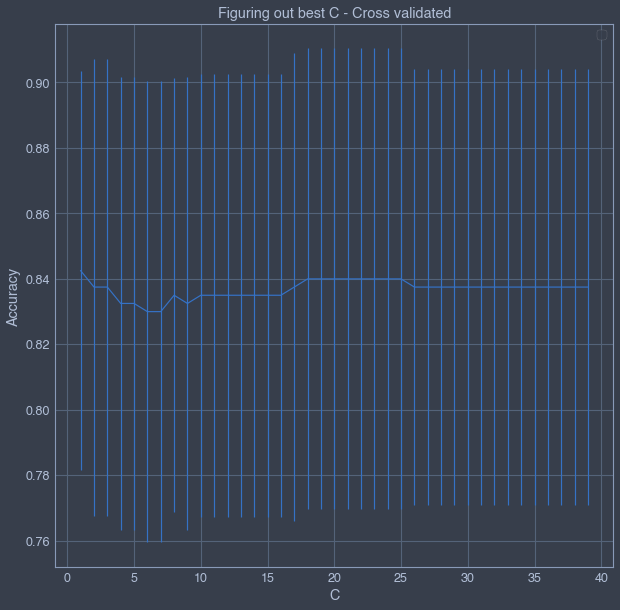

In [67]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
Cs = Cs = np.arange(1, 40, 1)
plt.figure(figsize=(10,10))
for c in Cs:
    clf = LogisticRegression(C=c, penalty='l2', solver='liblinear')
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Figuring out best C - Cross validated")
plt.plot()

## Propagation

In [68]:
# Addestriamo completamente il lessico
inducer = LogisticRegression(C=20, penalty='l2', solver='liblinear').fit(X,y)

## Scoring Certain

In [92]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [93]:
models_propagation_Hamilton = [{word: 
                       (inducer.predict([model.wv[word]])[0] + 1)/2
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_Hamilton = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_Hamilton)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model in slices.values()]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, 
                                                  vocab_counts_Hamilton, 
                                                  vocab_counts_abs)}

In [95]:
{k: v for k, v in sorted(models_score_Hamilton.items(), key=lambda item: item[1])}

{'New York Times': 0.5560650004426893,
 'CNN': 0.556412200232015,
 'News Max': 0.5653872259789239,
 'The Federalist': 0.5655937919825634,
 'ABC News': 0.5672699785846147,
 'Wikipedia': 0.5939066839813166,
 'Breitbart': 0.6263741654234439}

## Scoring Probability

In [99]:
models_propagation_Hamilton = [{word: 
                       inducer.predict_proba([model.wv[word]])[0][0]
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_Hamilton = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_Hamilton)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model in slices.values()]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: sum(count.values())/(sum(count_abs.values()))
                         for name, count, count_abs in zip(slices, 
                                                           vocab_counts_Hamilton, 
                                                           vocab_counts_abs)}

In [101]:
{k: v 
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])}

{'Breitbart': 0.3865936679153554,
 'Wikipedia': 0.39283746921702256,
 'The Federalist': 0.42980322411691685,
 'ABC News': 0.4412464769214533,
 'CNN': 0.4438646566301673,
 'News Max': 0.44433470097759153,
 'New York Times': 0.4462006110783193}

## Testing

In [102]:
prop_subj = [[key for key, val in models_propagation_test[i].items() 
              if val == 0]
                for i in range(7)]
print([len(model)for model in prop_subj])

[19262, 8930, 6203, 6870, 11296, 11642, 5451]


# No Propagation

## Scoring

In [83]:
# Load as dictionary the refined lexicon
with open("./lexicon_2/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]

In [84]:
models_propagation_none = [{word: 
                       (lexicon_refined[word])
  for word in lexicon_refined} for model in slices.values()]

vocab_counts_none = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in lexicon_refined} 
                for model, model_prop in zip(slices.values(), models_propagation_none)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation_none)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_none = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_none, 
                                            vocab_counts_abs)}

In [85]:
{k: v 
 for k, v in sorted(models_score_none.items(), 
                    key=lambda item: item[1])}

{'Wikipedia': 0.01615761917797048,
 'New York Times': 0.02604497701537687,
 'Breitbart': 0.026322552575257185,
 'News Max': 0.026722542294746254,
 'CNN': 0.02747633268967945,
 'ABC News': 0.0322908368404149,
 'The Federalist': 0.03311357565394937}

# Hamilton

In [4]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [6]:
# We have to remove some nan, because Hamilton sucks
propagations = {filename.split("_")[-1].replace(".csv", ""):
                pd.read_csv(filename, index_col=0).dropna()
                for filename in glob.glob('./propagations_2/*.csv')}

In [7]:
vocab_counts_Hamilton = {model_name: {row["Words"]: 
                      model.wv.vocab[row["Words"]].count * row["Labels"]
                for index, row in propagations[model_name].iterrows()} 
                for model, model_name in zip(slices.values(), 
                                             slices)}

# This is just the sum of all words in the corpus
vocab_counts_abs = {model_name: {word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_name in zip(slices.values(), 
                                                 slices)}
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: 
                         (sum(vocab_counts_Hamilton[name].values())
                          /(sum(vocab_counts_abs[name].values())))
                         for name in slices}

In [8]:
{k: v 
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])}

{'The Federalist': 0.5294697689020683,
 'CNN': 0.5432039610423294,
 'Breitbart': 0.5532589961924428,
 'News Max': 0.564340204865545,
 'ABC News': 0.5940396512189026,
 'Wikipedia': 0.6025457097622846,
 'New York Times': 0.6745870642411773}